In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [4]:
df_snp = pd.read_csv('data/raw/sp500.csv')
df_vix = pd.read_csv('data/raw/vix.csv')

# list of the finance dataframes
dataset_names = ['SP500', 'VIX']
dataframes = [df_snp, df_vix]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5031 non-null   object 
 1   Close   5031 non-null   float64
 2   High    5031 non-null   float64
 3   Low     5031 non-null   float64
 4   Open    5031 non-null   float64
 5   Volume  5031 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.0+ KB


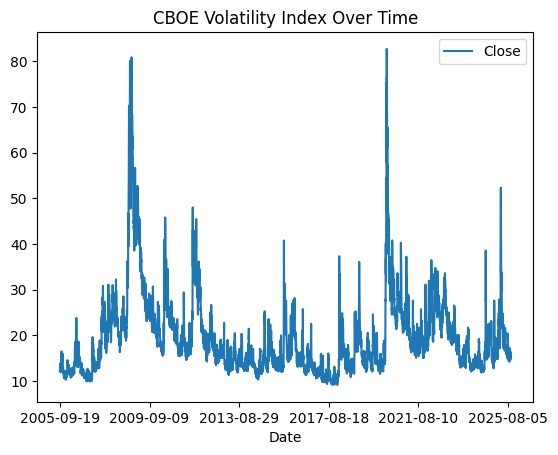

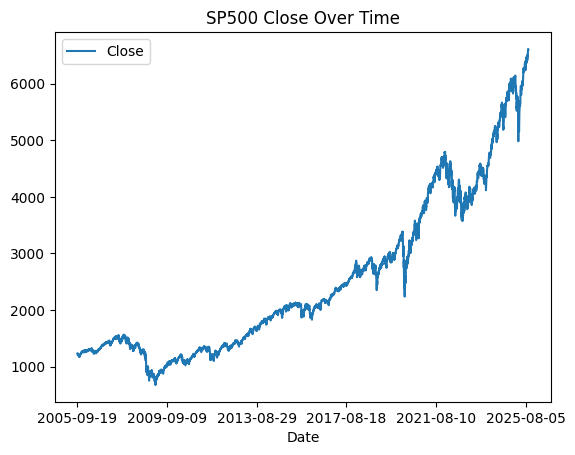

In [5]:
df_vix.plot(x='Date', y='Close', title='CBOE Volatility Index Over Time')
df_snp.plot(x='Date', y='Close', title='SP500 Close Over Time')
df_snp.info()

In [6]:
# Calculate log returns for each dataframe
# transform the 'Close' prices to log returns leading to stationarity
for i, df in enumerate(dataframes):
    df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
    df.dropna(inplace=True)  # Remove NaN values resulting from the shift

<Axes: title={'center': 'SP500 Log Returns Over Time'}, xlabel='Date'>

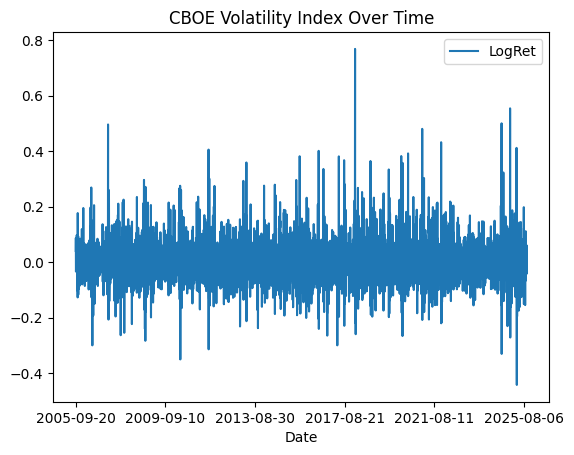

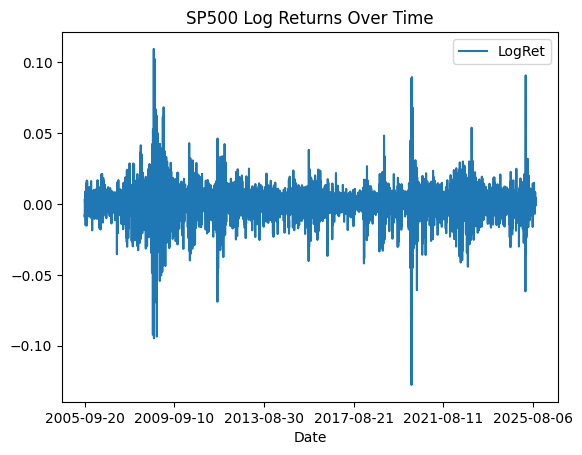

In [7]:
df_vix.plot(x='Date', y='LogRet', title='CBOE Volatility Index Over Time')
df_snp.plot(x='Date', y='LogRet', title='SP500 Log Returns Over Time')

## Second time around stationarity analysiss

In [8]:

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")


In [9]:
# Perform stationarity analysis on each dataframe
for i, df in enumerate(dataframes):
    stationarity_analysis(df=df, column_name="LogRet", dataset_name=dataset_names[i])


STATIONARITY ANALYSIS: SP500

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -17.945452
p-value: 0.000000
Critical Values:
	1%: -3.431655
	5%: -2.862117
	10%: -2.567077
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 0.189312
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: STATIONARY (Fail to reject null hypothesis)

--- COMBINED INTERPRETATION ---
CONCLUSION: Series is STATIONARY

STATIONARITY ANALYSIS: VIX

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -28.178470
p-value: 0.000000
Critical Values:
	1%: -3.431653
	5%: -2.862116
	10%: -2.567077
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 0.018648
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: STATIONARY (Fail to reject null hypothesis)

--- COMBINED INTERPRETATION ---
CONCLUSIO

In [10]:
for i, df in enumerate(dataframes):
    df.to_parquet(f'data/cleaned/{dataset_names[i].lower().replace(" ", "_")}.parquet', index=False)

# Electricity 

In [11]:
df_electricity = pd.read_csv('data/raw/electricity.txt', sep=';', parse_dates=[0], index_col=0)
# find columns where values aren't 0 in the first row
non_zero_columns = df_electricity.columns[df_electricity.iloc[0] != 0]
# keep only those columns
df_electricity = df_electricity[non_zero_columns]
# rename columns to remove spaces
df_electricity.columns = [col.strip().replace(' ', '_') for col in df_electricity.columns]
# save only the first 10 collumns and leave out the rest
df_electricity = df_electricity.iloc[:, :10]
df_electricity.reset_index(inplace=True)

for col in df_electricity.columns:
    if col != 'index':  # Skip the datetime index column
        df_electricity[col] = pd.to_numeric(df_electricity[col].str.replace(',', '.'), errors='coerce')

In [12]:
df_electricity

,index,MT_124,MT_131,MT_132,MT_156,MT_158,MT_159,MT_161,MT_162,MT_163,MT_166
0,2011-01-01 00:15:00,71.770335,260.416667,45.721750,68.203369,38.342246,20.363985,1935.185185,158.006363,1965.437788,838.461538
1,2011-01-01 00:30:00,71.770335,270.833333,39.190072,68.203369,38.342246,20.363985,1941.358025,181.336161,1746.543779,860.439560
2,2011-01-01 00:45:00,62.200957,260.416667,45.721750,68.203369,39.679144,20.363985,1978.395062,172.852598,2029.953917,794.505495
3,2011-01-01 01:00:00,71.770335,291.666667,45.721750,68.203369,41.016043,18.448276,1895.061728,166.489926,1997.695853,706.483516
4,2011-01-01 01:15:00,66.985646,270.833333,45.721750,68.827199,38.342246,19.406130,1975.308642,179.215270,1801.843318,717.582418
...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,244.019139,31.250000,45.721750,38.858391,73.128342,22.289272,1416.666667,94.379639,1248.847926,519.560440
140252,2014-12-31 23:15:00,143.540670,41.666667,45.721750,61.958827,73.128342,21.331418,1114.197531,100.742312,1131.336406,640.549451
140253,2014-12-31 23:30:00,114.832536,41.666667,39.190072,53.218964,73.128342,22.289272,1145.061728,108.165429,1112.903226,563.626374
140254,2014-12-31 23:45:00,138.755981,31.250000,45.721750,38.234560,70.454545,20.363985,1419.753086,99.681866,1191.244240,607.582418


Save only one client's elecricity consumption

In [13]:
df_electricity.to_parquet('data/cleaned/electricity.parquet', index=False)

# Online Retail

In [14]:
df_online_retail = pd.read_excel('data/raw/Online Retail.xlsx')
df_online_retail.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [15]:
mask2 = df_online_retail['CustomerID'].isna()
df_online_retail[mask2]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [16]:
df_online_retail['CustomerID'] = df_online_retail['CustomerID'].fillna(0)

In [17]:
# Convert object columns to string/text type
object_columns = df_online_retail.select_dtypes(include=['object']).columns
for col in object_columns:
    df_online_retail[col] = df_online_retail[col].astype(str)

In [18]:
df_online_retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [19]:
df_online_retail.to_parquet('data/cleaned/online_retail.parquet', index=False)

# Weather data
date format: 1980-01-01T01:00

In [20]:
df_weather = pd.read_csv('data/raw/Weather_Data_1980_2024(hourly).csv')
df_weather.isna().sum()

time                             0
temperature                      0
relative_humidity                0
dew_point                        0
precipitation (mm)               0
rain (mm)                        0
snowfall (cm)                    0
pressure_msl (hPa)               0
surface_pressure (hPa)           0
cloud_cover (%)                  0
cloud_cover_low (%)              0
cloud_cover_mid (%)              0
cloud_cover_high (%)             0
vapour_pressure_deficit (kPa)    0
wind_speed_10m (km/h)            0
wind_direction                   0
is_Day                           0
dtype: int64

In [21]:
df_weather.to_parquet('data/cleaned/weather.parquet', index=False)